In [12]:
from __future__ import division
import os
import torch
from torch import nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
from torch.autograd import Variable
import random
import math
from functools import reduce
from scipy import stats

import cv2
from glob import glob

import skimage
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from skimage.color import rgb2grey, rgb2hsv, hsv2rgb, grey2rgb, rgba2rgb
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import random
import math
from functools import reduce

import cv2
from glob import glob

import skimage
from skimage.io import imread
from skimage import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.util import invert
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.filters import gaussian

from skimage.morphology import erosion, dilation, binary_dilation, opening, closing, white_tophat
from skimage.morphology import disk

import sklearn
from skimage.morphology import label

import utils
from utils import show_images, plot_img_and_hist, add_contour
from loss import show_compare_gt

import main
#import ipy_autoreload
#%autoreload 2 
#%aimport your_mod

In [58]:
#transform = reload(transform)
reload(utils)
#reload(loss)
reload(architectures)
reload(main)

<module 'main' from 'main.py'>

In [4]:
import logging
from utils import exceptions_str
from skimage.morphology import reconstruction
from skimage import img_as_float, exposure
from skimage.util import invert
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation, binary_dilation, binary_opening, opening, closing, white_tophat
from skimage.morphology import disk
from scipy import ndimage as ndi


def parametric_pipeline(img,
                invert_thresh_pd = .5,
                circle_size = 7,
                disk_size=10,
                min_distance=9,
                use_watershed=False
                ):
    try:
        circle_size = np.clip(int(circle_size), 1, 30)
        if use_watershed:
            disk_size = np.clip(int(disk_size), 0, 50)
            min_distance = np.clip(int(min_distance), 1, 50)

        # Invert the image in case the objects of interest are in the dark side                                                                                  

        thresh = threshold_otsu(img)
        img_th = img > thresh

        if len(np.where(img_th)[0]) > invert_thresh_pd * img.size:
            img=invert(img)

        # morphological opening (size tuned on training data)                                                                                                    
        #circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))                                                                         
        circle7=disk(circle_size / 2.0)
        img_open = opening(img, circle7)
        #img_open = cv2.morphologyEx(img, cv2.MORPH_OPEN, circle7)                                                                                               
        #return img_open                                                                                                                                         

        thresh = threshold_otsu(img_open)
        img_th = (img_open > thresh).astype(int)
     # second morphological opening (on binary image this time)                                                                                               
        bin_open = binary_opening(img_th, circle7)
        if not use_watershed:
            return ndi.label(bin_open)[0], thresh

        # WATERSHED                                                                                                                                              
        selem=disk(disk_size)
        dil = binary_dilation(bin_open, selem)
        img_dist = ndi.distance_transform_edt(dil)
        local_maxi = peak_local_max(img_dist,
                                    min_distance=min_distance,
                                    indices=False,
                                    exclude_border=False)
        markers = ndi.label(local_maxi)[0]
        cc = watershed(-img_dist, markers, mask=bin_open, compactness=0, watershed_line=True)

        return cc
    except:
        logging.error("Error in parametric pipeline:\n%s" % exceptions_str())
        return np.zeros_like(img)


In [5]:
def train_transform(img, mask, mask_seg):
    # HACK (make dims consistent, first one is channels)                                                                                                         
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, 2)
    if len(mask_seg.shape) == 2:
        mask_seg = np.expand_dims(mask_seg, 2)
    #img, mask, mask_seg = random_rotate90_transform2(img, mask, mask_seg)
    img = ToTensor()(img)
    mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).float()
    mask_seg = torch.from_numpy(np.transpose(mask_seg, (2, 0, 1))).float()
    return img, mask, mask_seg

# Load Data

In [7]:
import dataset
utils=reload(utils)
import utils
import main
    
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
dsb_data_dir = os.path.join('..', '..', 'input')
stage_name = 'stage1'


dset = dataset.NucleusDataset(dsb_data_dir, stage_name, transform=train_transform)

# hack: this image format (1388, 1040) occurs only ones, stratify complains .. 
dset.data_df = dset.data_df[dset.data_df['size'] != (1388, 1040)]

stratify = dset.data_df['images'].map(lambda x: '{}'.format(x.size))
train_dset, valid_dset = dset.train_test_split(test_size=0.05, random_state=1, shuffle=True, stratify=stratify)
train_loader = DataLoader(train_dset, batch_size=1,shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=1,shuffle=True)



/Users/stefan/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Load Model

In [1170]:
import architectures
model = architectures.CNN()
path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/bce/model_save_bce_best.pth.tar'
#path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/mse_sgd/model_save_mse_sgd_best.pth.tar'
#path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/dice/model_save_dice_best.pth.tar'
main.load_checkpoint(path, model)

# Get Predictions

In [1171]:
# DISABLE AUGMENTATION!
train_dset.transform=train_transform
import torchvision
from torchvision.transforms import ToTensor, ToPILImage
model.eval()
preds = []
for i in tqdm(range(len(train_dset.data_df))):
    img, (mask, mask_seg) = train_dset[i]
    pred = model(Variable(img.unsqueeze(0),requires_grad=False)).data.numpy().squeeze()
    preds.append(pred)
train_dset.data_df['pred'] = preds

train_dset.data_df['pred'].iloc[0]
#plt.imshow(pred)



100%|██████████| 635/635 [09:51<00:00,  1.07it/s]
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


array([[-1.42175555, -2.66577339, -3.28632593, ..., -2.76240754,
        -2.24955726, -1.21701825],
       [-2.51710677, -4.64954042, -5.70425987, ..., -4.4556489 ,
        -3.69705176, -2.09826708],
       [-3.07127953, -5.66204453, -6.93678045, ..., -4.57528591,
        -3.84521103, -2.22584581],
       ..., 
       [-1.50806892, -2.36906672, -1.86764491, ..., -6.78779459,
        -5.63293695, -3.27456498],
       [-1.13978207, -1.86074769, -1.46729028, ..., -5.41785192,
        -4.48167992, -2.59180832],
       [-0.50473106, -0.94915801, -0.73943156, ..., -2.93361616,
        -2.42251873, -1.3894788 ]], dtype=float32)

# Calculate IOU For All Predictions

In [1172]:

threshs = []
pred_labels = []
ious = []
for i in tqdm(range(len(train_dset.data_df))):
    img_th, th = parametric_pipeline(train_dset.data_df['pred'].iloc[i],circle_size=4)
    ious.append(iou_metric(img_th, train_dset.data_df['masks'].iloc[i]))
    threshs.append(th)
    pred_labels.append(img_th)
train_dset.data_df['thresh'] = threshs
train_dset.data_df['iou'] = ious
train_dset.data_df['pred_label'] = pred_labels


#print np.mean(ious),np.median(ious)
#diagnose_errors(img_th[0][0],img_th[0][1])
#show_compare_gt(pred[2][0],pred[2][1],circle_size=10)
#print pred[0][0].dtype


100%|██████████| 635/635 [00:23<00:00, 26.54it/s]
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of

# Analyze

In [1173]:
scipy.stats.describe(train_dset.data_df['thresh'])

DescribeResult(nobs=635, minmax=(-4.5531831062398851, 4.5127340543549508), mean=-2.9869953806436649, variance=2.1385371314669501, skewness=2.2373925435307145, kurtosis=6.405262263404849)

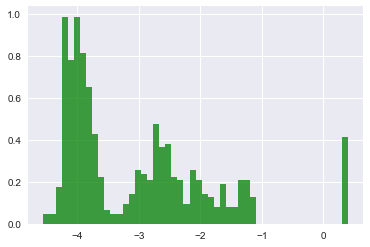

In [1174]:
plt.hist(train_dset.data_df['thresh'].map(lambda x: min(x, .4)), 50, normed=1, facecolor='green', alpha=0.75);

In [1218]:
print scipy.stats.describe(train_dset.data_df['iou'])
print np.median(train_dset.data_df['iou'])

DescribeResult(nobs=635, minmax=(0.0, 0.76360714285714282), mean=0.14130326926530865, variance=0.029872969934399477, skewness=1.3023859676234368, kurtosis=0.7502302308824929)
0.0625776397516


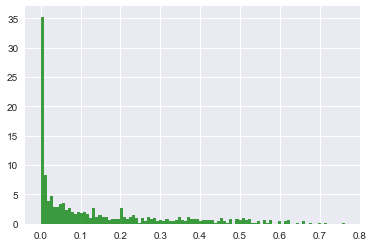

In [1177]:
plt.hist(train_dset.data_df['iou'], 100, normed=1, facecolor='green', alpha=0.75);

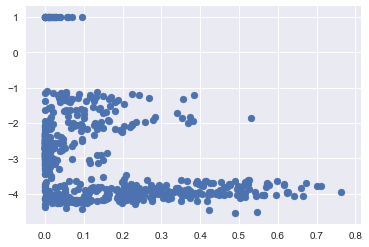

In [1179]:
plt.scatter(train_dset.data_df['iou'],train_dset.data_df['thresh'].map(lambda x: min(x, 1)))

# Try Fixed Thresholds

100%|██████████| 635/635 [00:10<00:00, 61.60it/s]


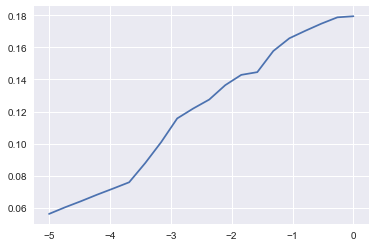

In [1217]:
p=train_dset.data_df['pred'].iloc[0]
def ious_at_thresh(thresh):
    l = []
    for i in tqdm(range(len(train_dset.data_df))):
        img_th = (train_dset.data_df['pred'].iloc[i] > thresh).astype(int)
        img_l = scipy.ndimage.label(img_th)[0]
        l.append(iou_metric(img_l, train_dset.data_df['masks'].iloc[i]))
    return l

threshs=np.linspace(-5, 0, 20)
i = [np.mean(ious_at_thresh(x)) for x in threshs]
plt.plot(threshs,i)


In [1216]:
from loss import union_intersection
#ious = ious_at_thresh(-4)
i=5
#print train_dset.data_df['thresh'].iloc[i]
#print train_dset.data_df['iou'].iloc[i]
#print ious[5]
img_th = (train_dset.data_df['pred'].iloc[i] > -3.72511933703).astype(int)
#show_images([train_dset.data_df['images'].iloc[i], img_th,train_dset.data_df['masks'].iloc[i]])
#print iou_metric(img_th, train_dset.data_df['masks'].iloc[i])
print img_th.max(), img_th.min()
#plt.hist(ious,bins=50);
labels=train_dset.data_df['masks'].iloc[i]
y_pred=img_th
union, intersection, _, _ = union_intersection(img_th, y_pred)

1 0
[[ 34608.]]


# Plot All Images With IOU 0


In [ ]:
train_dset.data_df['masks'].iloc[i]

(array([  5,  12,  19,  23,  29,  45,  49,  58,  60,  71,  73,  79,  82,
        93, 106, 109, 112, 114, 115, 126, 130, 135, 137, 142, 144, 150,
       151, 156, 157, 160, 164, 173, 183, 187, 193, 194, 195, 201, 211,
       227, 237, 240, 251, 257, 266, 270, 274, 286, 298, 302, 314, 316,
       318, 320, 322, 325, 326, 327, 341, 343, 346, 358, 359, 364, 373,
       380, 399, 402, 406, 409, 415, 418, 425, 436, 442, 444, 449, 450,
       453, 465, 474, 475, 482, 489, 509, 510, 518, 519, 521, 530, 535,
       537, 541, 547, 550, 551, 552, 557, 560, 575, 579, 580, 585, 594,
       599, 602, 604, 621, 629]),)


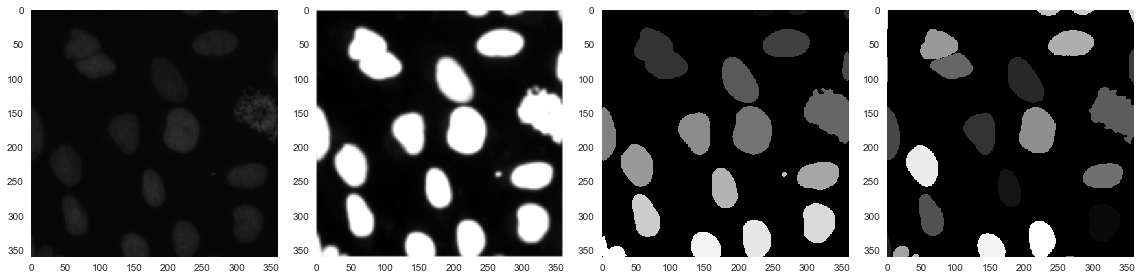

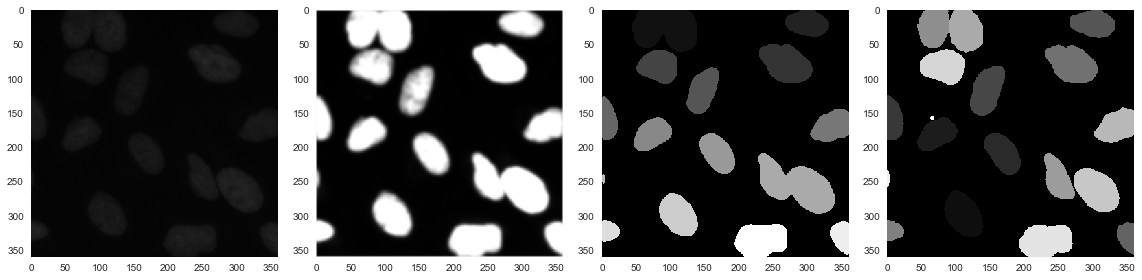

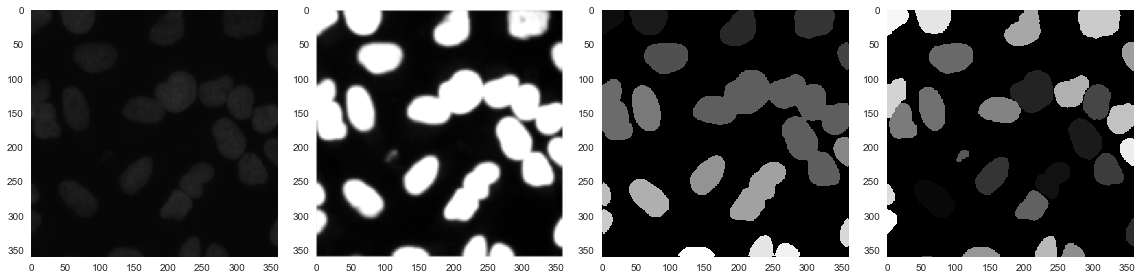

KeyboardInterrupt: 

In [1193]:
#sel = np.where(np.abs(train_dset.data_df['iou'] - 0.0) <=0.0)
sel = np.where(np.logical_and(train_dset.data_df['iou'] > 0.3, train_dset.data_df['thresh'] < -3))
print sel
for i in np.nditer(sel):
    i = np.asscalar(i)
    show_images([train_dset.data_df['images'].iloc[i],
        train_dset.data_df['pred'].iloc[i],
        train_dset.data_df['pred_label'].iloc[i],
        train_dset.data_df['masks'].iloc[i]], 4)


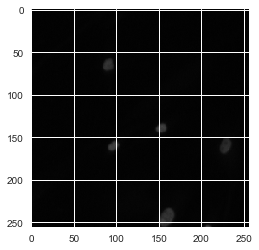

In [39]:
i=14
if 0:
    show_images([train_dset.data_df['images'].iloc[i],
        #train_dset.data_df['pred'].iloc[i],
        #train_dset.data_df['pred_label'].iloc[i],
        train_dset.data_df['masks'].iloc[i]], 4)
#utils.show_with_contour(train_dset.data_df['images'].iloc[i], 
#                        train_dset.data_df['masks'].iloc[i],
#                       color='green')

#ov = label2rgb(train_dset.data_df['pred_label'].iloc[i], train_dset.data_df['images'].iloc[i])
#fig, ax = plt.subplots(figsize=(20, 12))
#ax.imshow([1, 1, 1] * ov)
#fig, ax = plt.subplots(figsize=(16, 16))
#ax.hist(train_dset.data_df['pred'].iloc[i].flatten(), bins=50);

plt.imshow(train_dset.data_df['images'].iloc[i])

In [ ]:
# summary of image formats
dset.data_df.groupby(['format','mode','size']).size()

In [ ]:
modes = dset.data_df['images'].map(lambda x: x.mode)
sizes = dset.data_df['images'].map(lambda x: x.size)
print np.unique(sizes)

# Training

In [ ]:
from torch import optim

print_every = 10
save_every = 10
eval_every = 10
    
epochs = 10

if 1:
    model = CNN()
    it = 0
    best_loss = 1e20
    best_it = 0
    stats = []


criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = loss.DiceLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=1e-4)



#for epoch in range(epochs):
    # adjust_learning_rate(optimizer, epoch)
#    it, best_loss, best_it = train(train_loader, valid_loader, model, criterion, optimizer, stats, epoch, eval_every, print_every, save_every)
#print it, best_loss, best_it



# Single Example Training

loss: 1 0.692094266415 0.568050099918
loss: 2 0.689836382866 0.55675346947
loss: 3 0.686690986156 0.502710834586
loss: 4 0.682650864124 0.499263910636
loss: 5 0.677771031857 0.498544904403
loss: 6 0.672081947327 0.514547466577
loss: 7 0.665681004524 0.524191266894
loss: 8 0.658665239811 0.521499476914
loss: 9 0.651117682457 0.517582749458
loss: 10 0.643124580383 0.512674957053
loss: 11 0.634760379791 0.510589163308
loss: 12 0.626053452492 0.504989661761
loss: 13 0.617068588734 0.500210754738
loss: 14 0.607864141464 0.492290206606
loss: 15 0.598463475704 0.487689755259
loss: 16 0.588906228542 0.482059453239
loss: 17 0.579242050648 0.475702108711
loss: 18 0.569489181042 0.472924346465
loss: 19 0.559678435326 0.466017147423
loss: 20 0.549837231636 0.458231484986
loss: 21 0.539975106716 0.452686201194
loss: 22 0.53011739254 0.446656323022
loss: 23 0.520283222198 0.441170049252
loss: 24 0.510486066341 0.435665760171
loss: 25 0.500736474991 0.428697182561
loss: 26 0.491040498018 0.4229047561

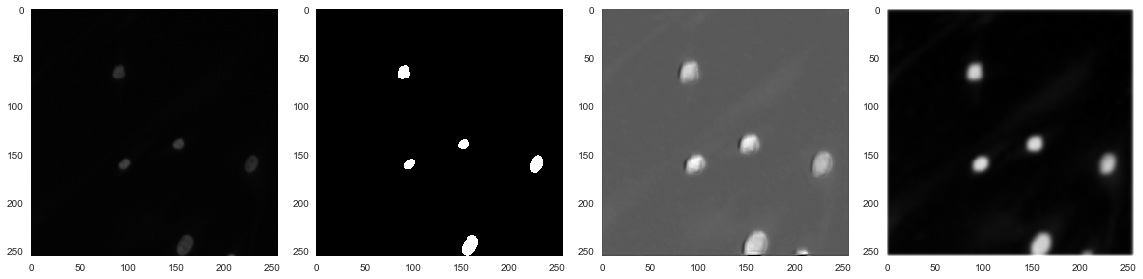

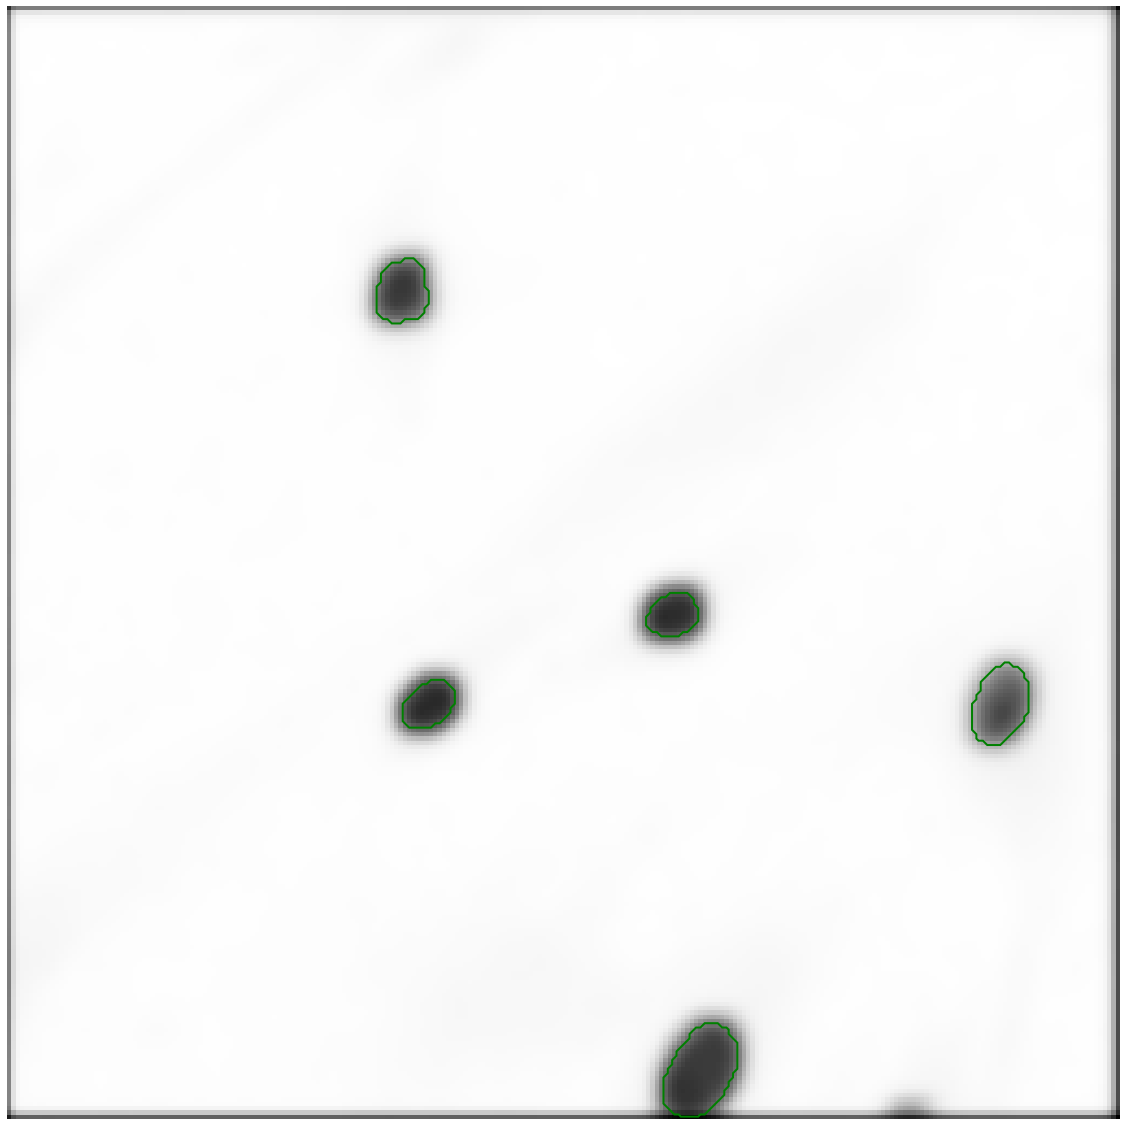

In [50]:
from adjust_learn_rate import adjust_learning_rate
from architectures import init_weights, CNN
idx = 14

if 1:
    model = CNN()
    init_weights(model,'xavier')
    #criterion = nn.MSELoss()
    criterion = nn.BCEWithLogitsLoss(torch.ones((1)))
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    #optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    it=0
    loss=[]
    lrs=[]
    grs=[]
    lr=0.01


lr=0.01
adjust_learning_rate(optimizer, lr)

img = train_dset.data_df['images'].iloc[idx]
masks = train_dset.data_df["masks"].iloc[idx]
masks_seg = train_dset.data_df["masks_seg"].iloc[idx]

img_trans, masks_trans, masks_seg_trans = train_transform(img, masks, masks_seg)
img_trans = img_trans.unsqueeze(0)
masks_seg_trans = masks_seg_trans.unsqueeze(0)

epochs=200
pred_before = None
for i in range(epochs):
    it += 1
    model.train(True)
    pred0 = model(Variable(img_trans))
    if i == 0:
        pred_before = pred0
    optimizer.zero_grad()
    loss0 = criterion(pred0, Variable(masks_seg_trans))
    loss0.backward()
    gr = torch.nn.utils.clip_grad_norm(model.parameters(), .25)
    #if it > 150:
    #    lr=0.01
    #    adjust_learning_rate(optimizer, lr)
    #if it > 20:
    #    lr=0.1
    #    adjust_learning_rate(optimizer, lr)
    optimizer.step()
    model.eval()
    pred1 = model(Variable(img_trans))
    loss1 = criterion(pred1, Variable(masks_seg_trans))
    loss.append(loss1.data[0])
    lrs.append(lr)
    grs.append(gr)
    print 'loss:', it, loss1.data[0], gr
    #if loss1.data[0] < 0.4 and it < 100:
    #    lr=0.01
    #    adjust_learning_rate(optimizer, lr)
    #if it >= 100:
    #    lr=0.001
    #    adjust_learning_rate(optimizer, lr)

    
pred_before = pred_before.data.squeeze().numpy()
pred1 = pred1.data.squeeze().numpy()
show_images([img, masks_seg, pred_before, pred1], max_col=4)
utils.show_with_contour(pred1, 
                        masks_seg.squeeze(),
                       color='green')




200


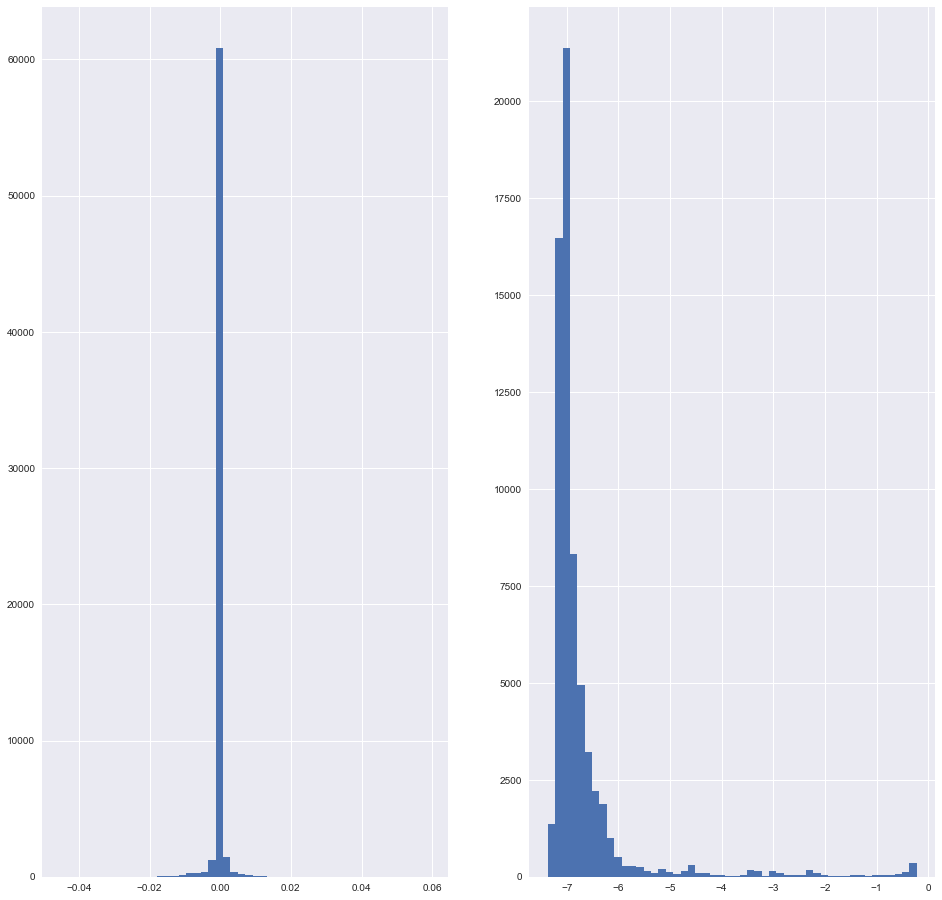

In [44]:
print it
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].hist(pred_before.flatten(), bins=50);
ax[1].hist(pred1.flatten(), bins=50);


200 0.01


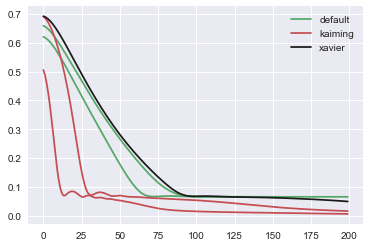

0.133979674858


In [52]:
print it,lr
#exp_const_001=(loss,lrs)
#exp_const_001_adam=(loss,lrs)
#exp_01_50=(loss,lrs)
#exp_decay_099=(loss,lrs)
#exp_clip_025=(loss,lrs)
#exp_clip_01=(loss,lrs)
#exp_switch_40=(loss,lrs)
#exp_switch_40_red100=(loss,lrs)
#exp_clip_050=(loss,lrs)
#exp_clip_025_warmup20=(loss,lrs)
#exp_clip_025_lower_150=(loss,lrs)
#exp_clip_025_wd=(loss,lrs)
#exp_clip_025_2=(loss,lrs)
#exp_clip_025_kaiming_2=(loss,lrs)
exp_clip_025_xavier=(loss,lrs)
fig, ax = plt.subplots( nrows=1, ncols=1 )
#ax.set_ylim((0.05,0.1))
#ax.set_xlim((100,200))
ax.plot(exp_clip_025[0], 'g', label='default')
ax.plot(exp_clip_025_2[0], 'g')
ax.plot(exp_clip_025_kaiming[0], 'r', label='kaiming')
ax.plot(exp_clip_025_kaiming_2[0], 'r')
ax.plot(exp_clip_025_xavier[0], 'k', label='xavier')
ax.legend()
#ax.plot(grs, 'r')
plt.show()    
#print pow(.1,(1.0/50))
print pow(0.99,200)
#scipy.stats.describe(grs)
#np.median(grs)

# Visualize Predictions

In [ ]:
import torchvision.transforms as TT
#monkeypatch(dset, 'transform', train_transform)
#train_dset.transform=train_transform
#valid_dset.transform=train_transform

model.eval()

for img,(_,mask) in iter(train_loader):
    break


pred = model(Variable(img,requires_grad=False))
color_adjust = model.get_color_adjust(Variable(img,requires_grad=False))
coarse = model.get_coarse(Variable(img,requires_grad=False))

show_images([img[0],color_adjust.data[0],mask[0]])
#show_images([img[0],coarse[0].data[0],coarse[1].data[0],coarse[2].data[0],mask[0]])
#show_images([img[0],pred.data[0],mask[0]])

#pred = ToPILImage()(pred.data[0])
#ii = np.array(pred.data[0].squeeze())
#plt.imshow(ii,cmap='gray')
#ii[abs(ii-0.1425)<=0.01]=1
#ii=mask[0]
#print ii.min(), ii.max(), ii.mean(), stats.mode(ii.flatten())
#show_images([img[0],pred.data[0],mask[0]])
#print criterion(pred,Variable(mask))
#print ((pred.data[0]-mask[0])* (pred.data[0]-mask[0])).sum()/pred.data[0].numel()
#print ((mask[0]-mask[0].mean())* (mask[0]-mask[0].mean())).sum()/mask[0].numel()
#print pred.data[0].size()
#plot_img_and_hist(pred.data[0])
#plot_img_and_hist([img,mask])
#mask.mean()
#mask.shape
#show_img([img,mask])
#train_dset.transform
#train_dset.transform=transforms.ToTensor()
#train_dset.transform
#TT.ToPILImage()(img)
#show_images(pred.data[0])
#plt.imshow(ToPILImage()(pred.data[0]))
#plt.imshow(pred.data[0].numpy().squeeze())
#plt.imshow(img_as_float(pred.data[0].numpy().squeeze()))

#print isinstance(pred.data[0], torch.Tensor)


#print baseline(train_loader, valid_loader, criterion, 1000)
#def is_inverted(img,invert_thresh_pd=10.0):
#    img_grey = img_as_ubyte(rgb2grey(img))
#    img_th = cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
#    return np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))

#print is_inverted(train_dset.data_df['images'].iloc[0])
#x = train_dset.data_df['images'].map(is_inverted)
#print np.where(train_dset.data_df['inv'])
#ii = train_dset.data_df['images'].iloc[71]
#plt.imshow(rgb2grey(ii),cmap='binary')
#plt.imshow(ii[:10,:10]-5)
#ii[:10,:10]

#show_images(rgb2grey(ii))

#plot_img_and_hist(rgb2grey(ii))
#train_dset.data_df['id'].iloc[71]
#print ii.dtype, ii.mean(), ii.max(), ii.min(), stats.mode(ii.flatten())
#plt.imshow(ii)

In [ ]:
# pixel correlation plot
x=pred.data[0].numpy().flatten()
y=mask[0].numpy().flatten()
plt.scatter(y,x)
plt.show()

In [ ]:
epoch,stats=load_model(model, optimizer)
print epoch, stats

# Calculate IOU

In [ ]:
#loss=reload(loss)
import scipy
from tqdm import tqdm
#post_process=reload(post_process)
import loss
import post_process
from post_process import parametric_pipeline
from loss import iou_metric, diagnose_errors, show_compare_gt
#model.eval()
#pred = [(model(Variable(img,requires_grad=False)).data.numpy().squeeze(), mask.numpy().squeeze()) for img, (mask,mask_seg) in tqdm(iter(train_loader))]
#pred = [(ToPILImage()(img.squeeze()),mask.numpy().squeeze()) for img, (mask,mask_seg) in iter(valid_loader)]
#img_th = [(parametric_pipeline(rgb2grey(np.asarray(img)),circle_size=4), mask) for img, mask in pred]
#ious = [iou_metric(i,m) for (i,m) in img_th]
print np.mean(ious),np.median(ious)
#diagnose_errors(img_th[0][0],img_th[0][1])
#show_compare_gt(pred[2][0],pred[2][1],circle_size=10)
#print pred[0][0].dtype
#pred[0]

In [ ]:
dice 0.239599661927 0.221256282842
jaccard 0.23728979728 0.189091591261
bce 0.279290088953 0.217723006553
mse 0.304971608193 0.309523258999
new arch
mse 0.158894834172 0.114834653566
bce mean = 0.17207, med = 0.12120
dice mean = 0.24912, med = 0.19799
img-weighted bce 0.22999, med = 0.18525

In [ ]:
###### dset.data_df['masks_unlabeled']=dset.data_df['masks_unlabled']

#for i,(img,mask) in enumerate(valid_loader):
#    break

#print mask[1].dtype
#dset.data_df['masks'].iloc[0].max()
#ii=np.array(((1,2,3),(4,5,5)),dtype=np.uint8)
#print torch.from_numpy(ii)
img=dset.data_df['images'].iloc[0]
m1=dset.data_df['masks'].iloc[0]
m2=dset.data_df['masks_seg'].iloc[0]
ii,mm1,mm2=train_transform(img,m1,m2)
print mm1.shape,mm2.shape

# Create small subset

In [1227]:
import shutil
stratify = dset.data_df['images'].map(lambda x: '{}'.format(x.size))
large_dset, small_dset = dset.train_test_split(test_size=0.05, random_state=1, shuffle=True, stratify=stratify)
path_in='/Users/stefan/Documents/nucleus/input/stage1_train'
path_out='/Users/stefan/Documents/nucleus/input/small_train'
for i in range(len(small_dset.data_df)):
    id = small_dset.data_df['id'].iloc[i]
    #print os.path.join(path_in, id)
    #print small_dset.data_df['path'].iloc[i]
    shutil.copytree(os.path.join(path_in, id), os.path.join(path_out, id))
    


OSError: [Errno 17] File exists: '/Users/stefan/Documents/nucleus/input/small_train/c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a'

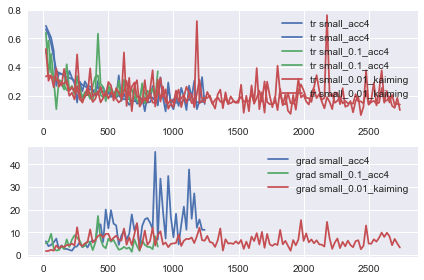

(<matplotlib.figure.Figure at 0x1c69ce7c10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c489fbf90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c5d331790>], dtype=object))

In [74]:
%%writefile compare.py
from utils import get_history_log
import architectures

fnames = ['experiments/small_acc4/model_save_small_acc4.1248.pth.tar',
        'experiments/small_0.1_acc4/model_save_small_0.1_acc4.896.pth.tar',
        'experiments/small_0.01_kaiming/model_save_small_0.01_kaiming.2752.pth.tar']
#path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/mse_sgd/model_save_mse_sgd_best.pth.tar'
#path='/Users/stefan/Documents/nucleus/data_science_bowl_2018/scripts/experiments/dice/model_save_dice_best.pth.tar'
def compare_learning(fnames):
    model = architectures.CNN()
    tr = []
    ts = []
    gr = []
    exps = []

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    # collect histories

    for fname in fnames:
        if not os.path.isfile(fname):
            raise ValueError('checkpoint not found: %s', fname)
        checkpoint = torch.load(fname)
        tr.append(get_history_log('train_loss', checkpoint['log']))
        ts.append(get_history_log('valid_loss', checkpoint['log']))
        gr.append(get_history_log('grad', checkpoint['log']))
        exps.append(checkpoint['global_state']['args'].experiment)

    # prepare plot
    fig, ax = plt.subplots(2, 1)
    for i in range(len(exps)):
        ax[0].plot(tr[i][1], tr[i][0], colors[i % len(colors)], label='tr ' + exps[i])
        ax[0].plot(ts[i][1], ts[i][0], colors[i % len(colors)], label='tr ' + exps[i])
        ax[1].plot(gr[i][1], gr[i][0], colors[i % len(colors)], label='grad ' + exps[i])
    
    ax[0].grid(True, 'both')
    ax[0].legend()
    ax[1].grid(True, 'both')
    ax[1].legend()
    plt.tight_layout()
     fig.savefig(fname)
    plt.close(fig)

compare_learning(fnames)
#os.path.isfile('experiments/small_0.1_acc4/model_save_small_0.1_acc4.')   

